<img src="logo_properati.png" width="450">

## Analysis of the properties for sale in GBA and CABA

Practical work 1 is based on data analysis from the historical record of property sales publications in Properati. The company provided us with the [data](http://www.properati.com.ar/data) of all the publications of the last 4 years, and to limit the scope of practical work, we will only work with the sales publications, and we will take into account the area of GBA and CABA.

## Generic setup

Import the modules which we need to perform the analysis of the properties dataset.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from shapely.geometry import Point
sns.set(style='white', color_codes=True)

%matplotlib inline
plt.rcParams["figure.figsize"] = (25, 10)

## Properties dataset

### Description

According to the Properati's web page, the information about each property included in the dataset is the following:
  * Creation date
  * Property type (house, apartment or ph)
  * Operation type (sell, rent)
  * Place name
  * Place name + "parents'" name
  * GeoNames ID (if avaiable)
  * Latitude
  * Longitude
  * Original price
  * Original currency (ARS, USD)
  * Price in local currency (ARS)
  * Approximate price in USD
  * Area in m²
  * Covered area in m²
  * Price in USD / m²
  * Price per m²
  * Floor number (if applicable)
  * Rooms
  * Properati URL  
  * Description
  * Title
  * URL of a thumbnail of the first photo

## Load the dataset

We load the all the dataset, each data frame is stored as a value of a dictionary which uses a tuple in the form of *(year, month)* as key.

In [3]:
import os

properatiDataFrames = dict()
datasetDirectory = 'data'
for filename in os.listdir(datasetDirectory):
    if filename.endswith('csv'):
        year, month = filename.split('-')[2:4]
        key = (int(year), int(month))
        dataFrame = pd.read_csv(os.path.join(datasetDirectory, filename))
        if len(dataFrame) == 0:
            print('Warning: the dataframe "{0}" is empty!'.format(filename))
        else:
            properatiDataFrames[key] = dataFrame 

## Initial exploratory analysis

### How many publications are in the dataset?

In order to obtain a measure of the volume of data to be analyzed, we can count how many publications are in the dataset.

In [4]:
totalPublications = sum((len(df) for df in properatiDataFrames.values()))
print('The dataset has {0} publications'.format(totalPublications))

The dataset has 3076984 publications


### What common columns are in the dataset?

Despite the Properati's web page indicates that all datasets have the same columns, we want to make sure of that.

In [5]:
columns = [set((c for c in df.columns)) for df in properatiDataFrames.values()]
common_columns = set.intersection(*columns)

print('The dataset has the following common columns:')
print(*common_columns, sep='\n')

The dataset has the following common columns:
lat-lon
price_aprox_local_currency
image_thumbnail
price_aprox_usd
lon
floor
geonames_id
place_with_parent_names
operation
currency
rooms
properati_url
price
place_name
expenses
lat
created_on
property_type
price_usd_per_m2


Note that not all datasets have all the columns.

### What does a random sample look like?

At this point we know what columns have the dataset, but let's go ahead and take a sample.

In [6]:
import random

df = random.choice(list(properatiDataFrames.values()))
df.sample(5)

,created_on,operation,property_type,place_name,place_with_parent_names,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_in_m2,price_usd_per_m2,floor,rooms,expenses,properati_url,image_thumbnail
58868,2013-12-18,sell,house,San Martín,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,NaN,"-34.579548,-58.537268",-34.579548,-58.537268,230000,USD,1583435.0,230000,191,1204.188482,NaN,NaN,NaN,http://www.properati.com.ar/c9h9_venta_casa_sa...,http://cf-thumbs.properati.com.ar/SjUCdC29vMg9...
52689,2013-12-09,sell,apartment,Caballito,|Argentina|Capital Federal|Caballito|,3435874,"-34.610627,-58.450667",-34.610627,-58.450667,135000,USD,929407.5,135000,51,2647.058824,NaN,3,NaN,http://www.properati.com.ar/bzzd_venta_departa...,http://cf-thumbs.properati.com.ar/Z95-Kip1XKxR...
7068,2013-02-07,sell,apartment,Balvanera,|Argentina|Capital Federal|Balvanera|,6693228,"-34.599666,-58.406319",-34.599666,-58.406319,113000,USD,777948.5,113000,NaN,NaN,NaN,2,NaN,http://www.properati.com.ar/5nzu_venta_departa...,http://cf-thumbs.properati.com.ar/-qEYpQyS7bX2...
69700,2014-01-30,sell,apartment,San Telmo,|Argentina|Capital Federal|San Telmo|,3428113,"-34.618445,-58.375825",-34.618445,-58.375825,115000,USD,791717.5,115000,58,1982.758621,4,NaN,NaN,http://www.properati.com.ar/ct5b_venta_departa...,http://cf-thumbs.properati.com.ar/BemtSLGLNID1...
64056,2014-01-09,sell,apartment,Mar del Plata,|Argentina|Buenos Aires Costa Atlántica|Mar de...,3430863,"-37.992068,-57.54797",-37.992068,-57.547970,110000,USD,757295.0,110000,NaN,NaN,NaN,3,NaN,http://www.properati.com.ar/ck0i_venta_departa...,http://cf-thumbs.properati.com.ar/9n8JBQT7XPwq...


### Verify that the dataset contains only sales

Although it is assumed that the dataset we have contains only properties for sale, we will verify it because as we saw with what happened in the columns, we can not assume anything.

In [7]:
assert(sum(len(df[df.operation != 'sell']) for df in properatiDataFrames.values()) == 0)

### Filter the dataset

As we're only interested on the sales in GBA and CABA, we need to filter them. In addition, we can remove the unnecessary columns.

In [8]:
cabaDataFrames = dict()
gbaDataFrames = dict()

for key, df in properatiDataFrames.copy().items():
    # Remove the publications which price is NaN
    df.dropna(axis=0, subset=['price'], inplace=True)
    
    # Remove the publications which price is lower or equal than zero
    df['price'] = df['price'].astype(float)
    df = df[df.price > 0]

    # Cosmetic improvement
    df['property_type'] = df['property_type'].map(lambda x: str(x).title())

    # Create a new column which will be used to leverage the geopandas module 
    df['lat'].fillna(0, inplace=True)
    df['lon'].fillna(0, inplace=True)
    df['lat'] = df['lat'].astype(float)
    df['lon'] = df['lon'].astype(float)
    df['geometry'] =  df.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

    # Remove unnecessary columns
    df.drop('lat', inplace=True, axis=1)
    df.drop('lon', inplace=True, axis=1)
    df.drop('lat-lon', inplace=True, axis=1)
    df.drop('operation', inplace=True, axis=1)
    df.drop('geonames_id', inplace=True, axis=1)
    df.drop('properati_url', inplace=True, axis=1)

    # Filter publications
    year, month = key
    if month == 1:
        month = 12
        year -= 1
    else:
        month -= 1
    df['created_on'] =  pd.to_datetime(df['created_on'])
    df = df[(df.created_on.dt.month == month) & (df.created_on.dt.year == year)]
    
    # Segregate the data frame in two, one for each location
    cabaDataFrames[key] = df[df.place_with_parent_names.str.contains('Capital Federal')]
    gbaDataFrames[key] = df[df.place_with_parent_names.str.contains('G.B.A')]

    # At this point we can remove the "place_with_parent_names" since it does not provide us with information
    cabaDataFrames[key].drop('place_with_parent_names', inplace=True, axis=1)
    gbaDataFrames[key].drop('place_with_parent_names', inplace=True, axis=1)

del properatiDataFrames

Now, we can merge the data frames into a one per location.

In [9]:
def getDataFrame(dataFrames):
    resultDataFrame = None
    for dataFrame in dataFrames:
        # Perform lazy initialization, then append the data frames
        if resultDataFrame is None:
            resultDataFrame = dataFrame
        else:
            resultDataFrame = resultDataFrame.append(dataFrame)
    return resultDataFrame

cabaDataFrame = getDataFrame(cabaDataFrames.values())
gbaDataFrame = getDataFrame(gbaDataFrames.values())

del cabaDataFrames
del gbaDataFrames

##  Exploratory analysis

### What are the basic statistics on each dataset?

Now that we have a different data frame for each area (CABA and GBA), we can obtain some basic statistics.

In [10]:
cabaDataFrame.describe()

,floor,price,price_aprox_local_currency,price_aprox_usd,price_per_m2,price_usd_per_m2,rooms,surface_covered_in_m2,surface_in_m2,surface_total_in_m2
count,33699.000000,153779.000000,1.537770e+05,153777.000000,58346.000000,106858.000000,104602.00000,58924.000000,65318.000000,48700.000000
mean,11.332413,322130.427731,2.674169e+06,224177.656508,5215.839558,2549.800864,2.49304,97.325368,82.912260,120.350637
std,82.270590,741195.477894,4.739974e+06,344779.836013,17855.467398,4476.473715,1.41365,1130.597876,158.347569,1084.515533
min,1.000000,200.000000,3.999994e+04,4699.600000,2.224587,2.008584,0.00000,0.000000,0.000000,0.000000
25%,2.000000,96000.000000,9.103588e+05,93000.000000,2080.577957,1780.000000,1.00000,38.000000,38.000000,42.000000
50%,4.000000,148000.000000,1.499366e+06,135700.000000,2636.363636,2222.222222,2.00000,56.000000,54.000000,64.000000
75%,7.000000,285000.000000,2.729322e+06,230000.000000,3400.000000,2770.248999,3.00000,96.000000,90.000000,111.000000
max,7071.000000,50034183.000000,7.432609e+08,46545445.000000,2600000.000000,1271027.083333,40.00000,187000.000000,8457.000000,200000.000000


In [11]:
gbaDataFrame.describe()

,floor,price,price_aprox_local_currency,price_aprox_usd,price_per_m2,price_usd_per_m2,rooms,surface_covered_in_m2,surface_in_m2,surface_total_in_m2
count,24121.000000,1.988600e+05,1.988600e+05,198860.000000,80109.000000,126368.000000,82477.000000,81391.000000,76023.000000,63253.000000
mean,16.947971,3.293339e+05,3.047722e+06,247397.705136,3991.659763,1523.682349,2.903415,165.619847,308.039777,294.697342
std,152.827676,7.110257e+05,4.675345e+06,356422.080291,22464.210034,2825.913847,1.422312,3509.092436,1358.760323,1764.524358
min,1.000000,5.000000e+03,3.999994e+04,5000.000000,0.062760,0.080000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.050000e+05,1.080432e+06,95000.000000,1360.000000,753.895393,2.000000,53.000000,52.000000,58.000000
50%,2.000000,1.800000e+05,1.916220e+06,163197.670000,1800.000000,1351.247104,3.000000,98.000000,120.000000,130.000000
75%,5.000000,3.500000e+05,3.527920e+06,290000.000000,2465.753425,1923.076923,4.000000,198.000000,320.000000,300.000000
max,5402.000000,1.234568e+08,7.984250e+08,50000000.000000,3999999.960000,672409.805000,35.000000,987897.000000,144585.000000,200000.000000


These are a simple description about each dataframe. Now, we will analyze diferentes situations with boths dataframes

### How many publications are in each dataset?

Compare the proportion with the total amount of publications.

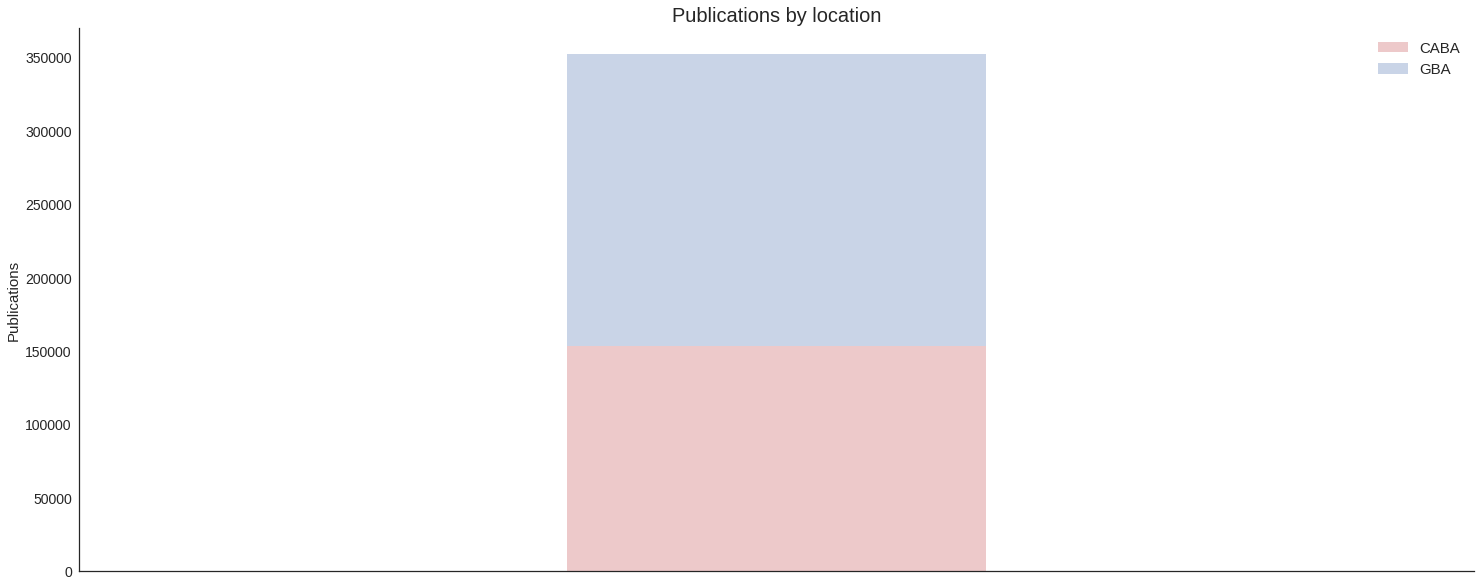

In [12]:
cabaPulications = len(cabaDataFrame)
gbaPublications = len(gbaDataFrame)

ind = np.arange(1)

fig, ax = plt.subplots(1)

ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)        
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
ax.set_xlim(-5, 5)

plt.xticks(ind, '', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('')
plt.ylabel('Publications', fontsize=15)
plt.title('Publications by location', fontsize=20)

p1 = plt.bar(ind, cabaPulications, color='r', alpha=0.3, width=3)
p2 = plt.bar(ind, gbaPublications, bottom=cabaPulications, color='b', alpha=0.3, width=3)

plt.legend((p1[0], p2[0]), ('CABA', 'GBA'), fontsize=15)
plt.show()

As expected, since the area of GBA is larger, there are fewer publications in CABA than in GBA.

### Which kind of properties can we find in the dataset?

In this part, we will try to analyze what types of properties are for sale in GBA and CABA. Also, we want to see if one property type predominate over another in the different regions.

In [13]:
gbaPropertyType = gbaDataFrame.groupby('property_type')['property_type']
cabaPropertyType =cabaDataFrame.groupby('property_type')['property_type']

In [14]:
def pieChartPlot(dataFrame, city):
    from matplotlib import font_manager as fm
    fig = plt.figure(1, figsize=(6,6))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    ttl = plt.title('Property types in ' + city, fontsize=20)
    ttl.set_position([.5, 1.05])
    fracs = dataFrame.count()
    labels = 'Apartment', 'House', 'PH', 'Store'

    patches, texts, autotexts = ax.pie(fracs, labels=labels, autopct='%1.1f%%',shadow=False, startangle=90, explode=(0.1, 0.1, 0.1, 0.1),pctdistance=1.1, labeldistance=1.2)
    proptease = fm.FontProperties()
    plt.setp(autotexts, fontproperties=proptease)
    plt.setp(texts, fontproperties=proptease)

    plt.show()

#### Property types in CABA

In [15]:
cabaPropertyType.describe()

property_type        
Apartment      count        128795
               unique            1
               top       Apartment
               freq         128795
House          count         10686
               unique            1
               top           House
               freq          10686
Ph             count         10400
               unique            1
               top              Ph
               freq          10400
Store          count          3898
               unique            1
               top           Store
               freq           3898
dtype: object

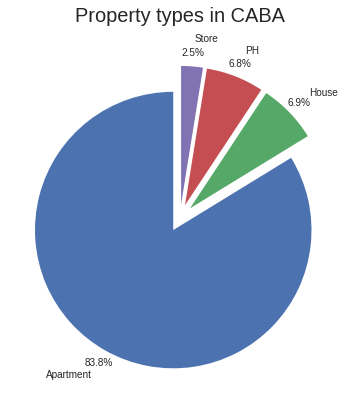

In [16]:
pieChartPlot(cabaPropertyType, 'CABA')

#### Property types in GBA

In [17]:
gbaPropertyType.describe()

property_type        
Apartment      count         83384
               unique            1
               top       Apartment
               freq          83384
House          count        100065
               unique            1
               top           House
               freq         100065
Ph             count         11504
               unique            1
               top              Ph
               freq          11504
Store          count          3907
               unique            1
               top           Store
               freq           3907
dtype: object

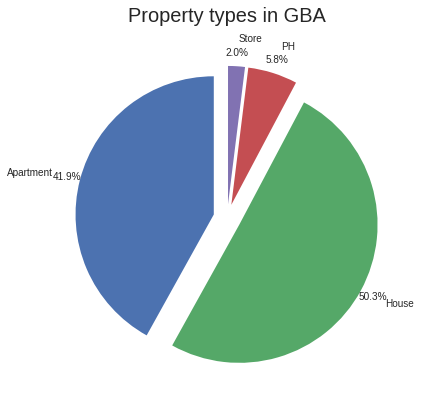

In [18]:
pieChartPlot(gbaPropertyType, 'GBA')

In the PieChart we can see how predomine the type *Apartment* in CABA, but in GBA *House* and *Apartment* are the most common type.

### Property type distribution

We want to do a comparative plot, where we show how many properties of each type are in GBA and CABA.

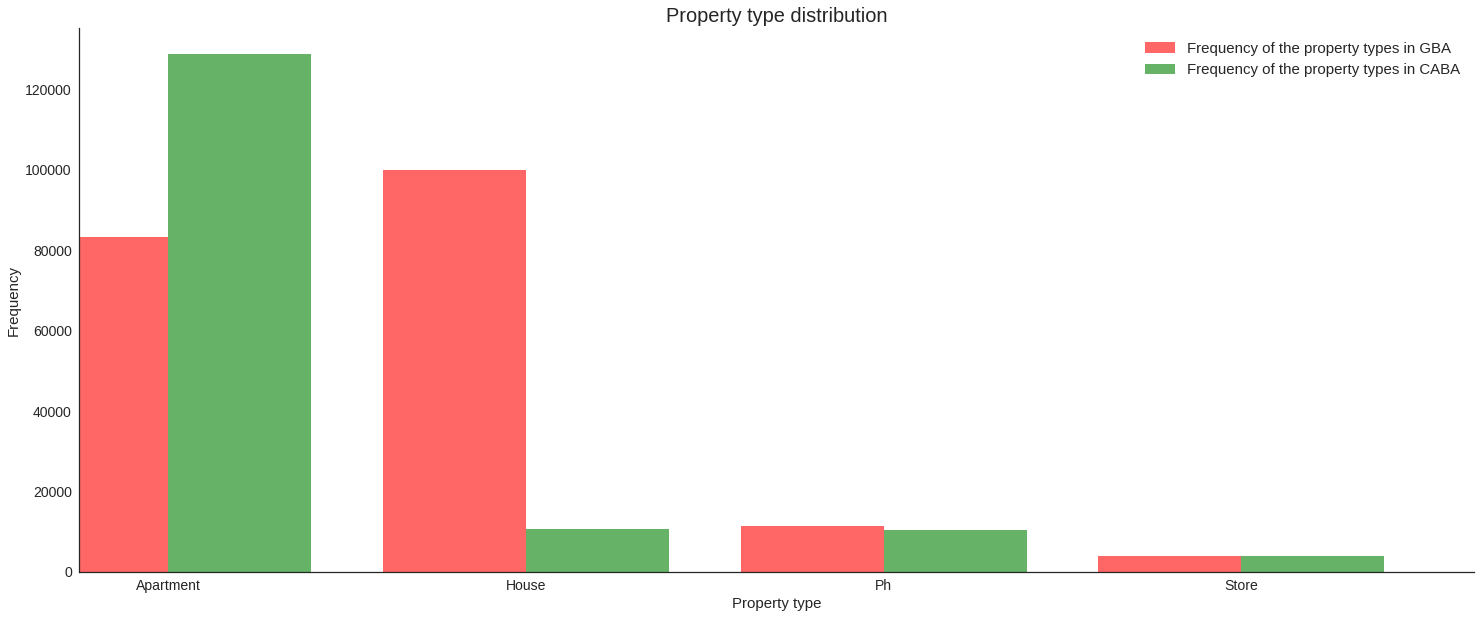

In [19]:
fig = plt.figure() 
width = 0.4
alpha = 0.6

ax = fig.add_subplot(111)

gbaDataFrame.groupby(['property_type']).property_type.count().plot(kind='bar', ax=ax, color='red', alpha=alpha, width=width, position=1, rot=0)
cabaDataFrame.groupby(['property_type']).property_type.count().plot(kind='bar', ax=ax, color='green', alpha=alpha, width=width, position=0, rot=0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Property type', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title('Property type distribution', fontsize=20)
plt.legend(['Frequency of the property types in GBA', 'Frequency of the property types in CABA'], fontsize=15);
plt.show()

How we supose, *Apartment* predomine in CABA but GBA have a lot of this type too. But with *House* type, the diferences are biggest, this type is very common in GBA, we deduce that this is a product of how the constructions are distributed in each region.

### How many rooms are the common in each property type?

We want to show in this plot how many rooms are the common in each property type in GBA and CABA.

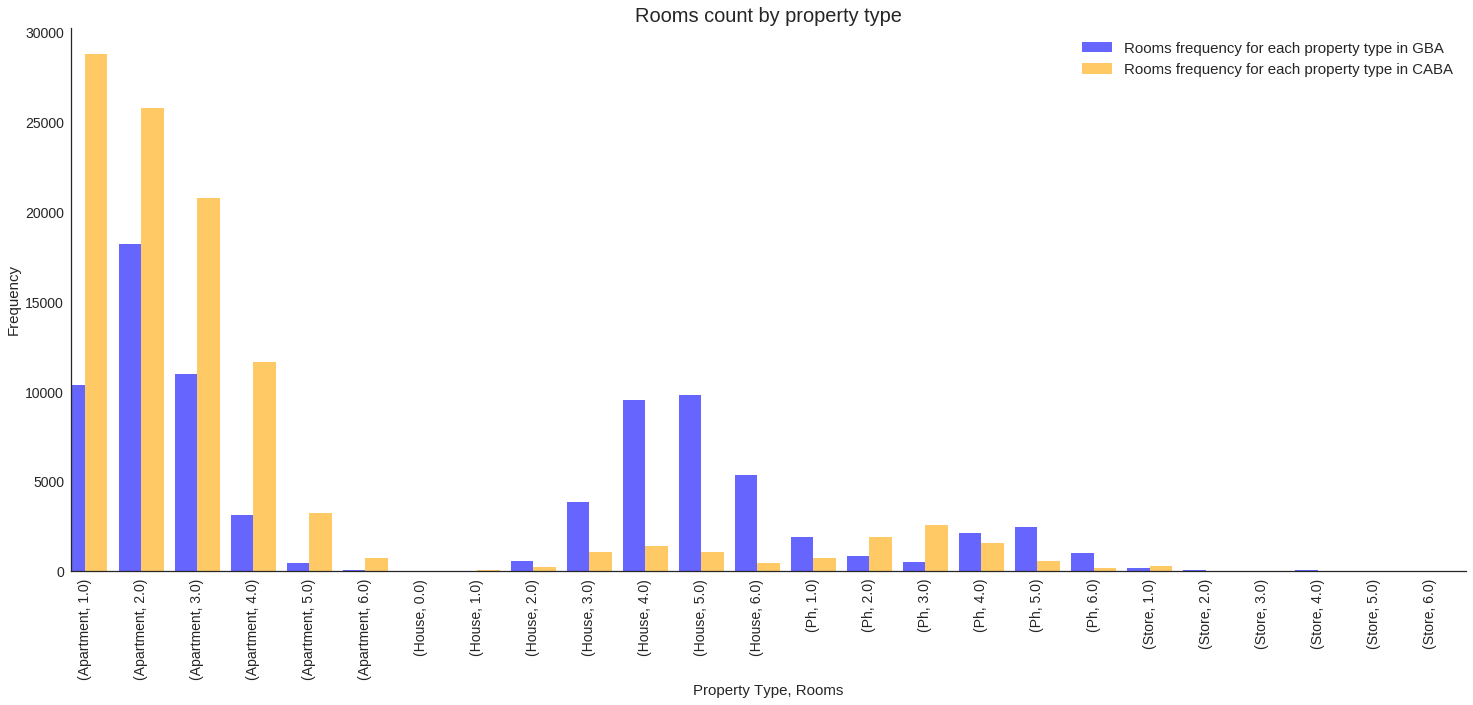

In [20]:
fig = plt.figure() 
width = 0.4
alpha = 0.6

ax = fig.add_subplot(111)

gbaRooms = gbaDataFrame[np.abs(gbaDataFrame.rooms- gbaDataFrame.rooms.mean()) <= (3 * gbaDataFrame.rooms.std())]
gbaRooms.groupby(['property_type','rooms']).rooms.count().plot(kind='bar', color='blue', alpha=alpha, width=width, position=1, ax=ax)

cabaRooms = cabaDataFrame[np.abs(cabaDataFrame.rooms- cabaDataFrame.rooms.mean()) <= (3 * cabaDataFrame.rooms.std())]
cabaRooms.groupby(['property_type','rooms']).rooms.count().plot(kind='bar', color='orange', alpha=alpha, width=width, position=0, ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylabel('Frequency', fontsize=15);
plt.xlabel('Property Type, Rooms', fontsize=15);

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title('Rooms count by property type', fontsize=20)
plt.legend(['Rooms frequency for each property type in GBA', 'Rooms frequency for each property type in CABA'], fontsize=15);
plt.show()

As we can see in the chart, CABA dominates the departments in front of the other types of property. In addition, most of the properties in CABA are apartments with up to 4 rooms, and as the number of rooms increases, their frequency decreases.

On the other hand, in GBA it is observed that there is not a very big difference in the amount of rooms in the houses and departments, except in the case of the departments with two rooms which seem to be more popular.

### How many rooms are the most common?

In this case, we want to show what is the difference in the average of the rooms in the properties that are for sale in CABA and GBA. We expect in CABA more properties with 1 or 2 rooms than in GBA.

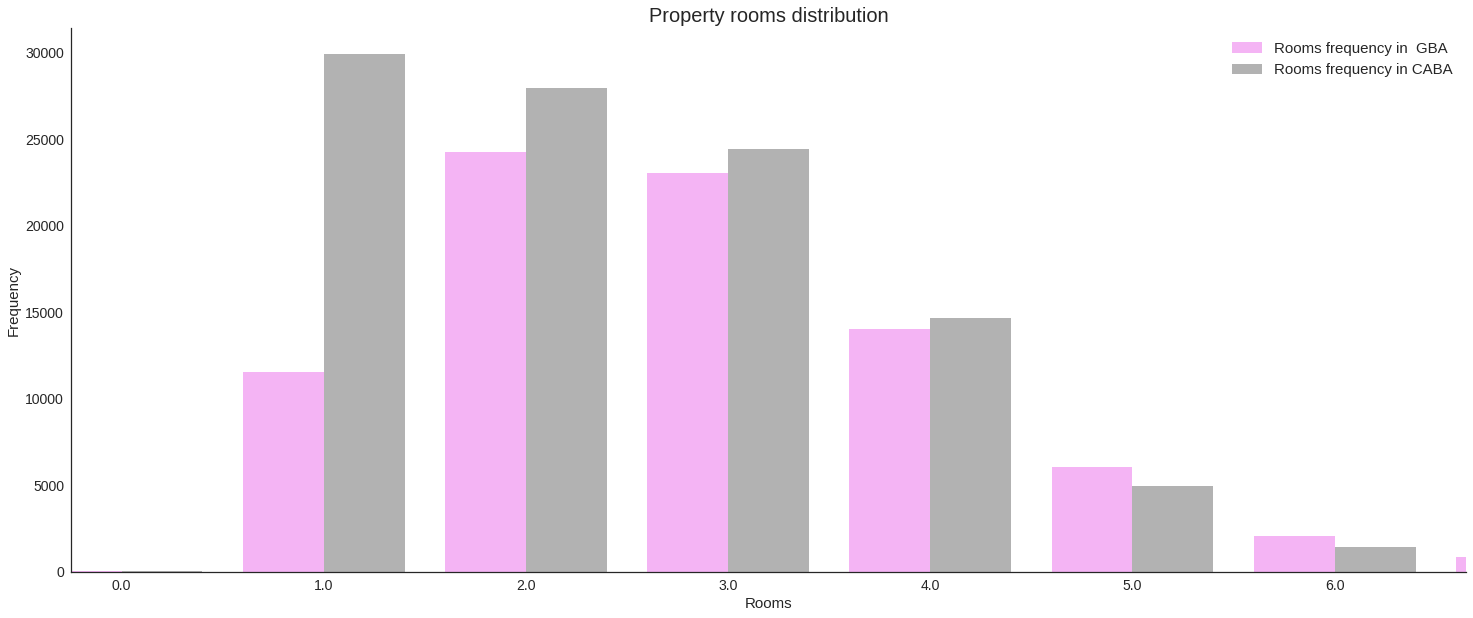

In [21]:
fig = plt.figure() 
ax = fig.add_subplot(111)
alpha = 0.6

gbaRooms = gbaDataFrame[np.abs(gbaDataFrame.rooms- gbaDataFrame.rooms.mean()) <= (3 * gbaDataFrame.rooms.std())]
gbaRooms.groupby(['rooms']).rooms.count().plot(kind='bar', color='violet', alpha=alpha,xticks=range(1,8), width=width, position=1, ax=ax, rot=0)

cabaRooms = cabaDataFrame[np.abs(cabaDataFrame.rooms- cabaDataFrame.rooms.mean()) <= (3 * cabaDataFrame.rooms.std())]
cabaRooms.groupby(['rooms']).rooms.count().plot(kind='bar', color='gray', alpha=alpha, xticks=range(1,8), width=width, position=0, ax=ax, rot=0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Rooms', fontsize=15)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title('Property rooms distribution', fontsize=20)
plt.legend(['Rooms frequency in  GBA', 'Rooms frequency in CABA'], fontsize=15)
plt.show()

How we shown previously, properties which only one room are more common in CABA than in GBA. Also, the probability of found a property with more rooms decrease as the amount of rooms increase in both CABA and GBA.

### How many publications are in each month?

With this plot, we want to show how many publications were on sale in each month during the five four years.

In [22]:
dataFrame = cabaDataFrame[['created_on']].append(gbaDataFrame[['created_on']]).dropna()
dataFrame['month'] = dataFrame.created_on.dt.strftime('%B')
dataFrame['year'] = dataFrame.created_on.dt.year
dataFrame.drop('created_on', inplace=True, axis=1)

In [23]:
grouped = dataFrame.groupby(['year', 'month']).size()
grouped.name = 'count'

In [24]:
countsDataFrame = pd.DataFrame(grouped).reset_index()

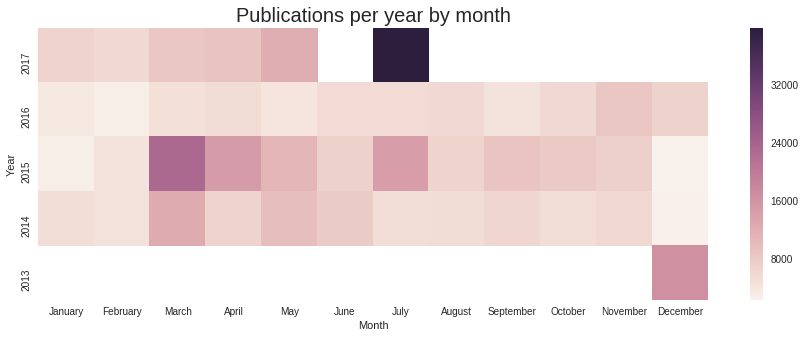

In [25]:
import calendar
matrix = pd.pivot_table(countsDataFrame, index='year', columns='month', values='count')
matrix = matrix[calendar.month_name[1:]]
    
fig, ax = plt.subplots(1, figsize=(15, 5))
axesSubplot = sns.heatmap(matrix)
axesSubplot.invert_yaxis()
axesSubplot.set(xlabel='Month', ylabel='Year')
ax.set_title('Publications per year by month', fontsize=20)
plt.show()

Aclarations, files from January, June 2017 and November 2016 are corrupt. For this the heatmap in these months are in white.

#### Publications per Year by Month in each region

With this plot, we want to show how many publications were on sale in each month during the four last years.

In [26]:
def addYearAndMonthColumns(dataFrame):
    newDataFrame = dataFrame[['created_on']].dropna()
    newDataFrame['Year'] = newDataFrame.created_on.dt.year
    newDataFrame['Month'] = newDataFrame.created_on.dt.month
                                         
    newDataFrame['Year'] = pd.to_numeric(newDataFrame['Year'])
    newDataFrame['Month'] = pd.to_numeric(newDataFrame['Month'])
    return newDataFrame

In [27]:
cabaNewDataFrame = addYearAndMonthColumns(cabaDataFrame)
gbaNewDataFrame = addYearAndMonthColumns(gbaDataFrame)

In [28]:
def plotPublicationsByYearByMonth(dataFrame, state):
    import calendar
    fig, ax = plt.subplots(1)

    ax.spines['top'].set_visible(False) 
    ax.spines['right'].set_visible(False)        
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()

    plt.xticks(np.arange(1, 13), [calendar.month_name[i] for i in range(1, 13)], fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Month', fontsize=15)
    plt.ylabel('Amount of publications', fontsize=15)
    
    plt.title('Publications by Year by Month in ' + state, fontsize=20)

    for year in range(2014, 2017 + 1):
        newDataFrame = dataFrame[dataFrame['Year'] == year]
        if len(newDataFrame) != 0:
            newDataFrame.groupby(['Month']).Month.count().plot(xticks=range(1, 13), label='Year %d' % year);

    plt.legend()

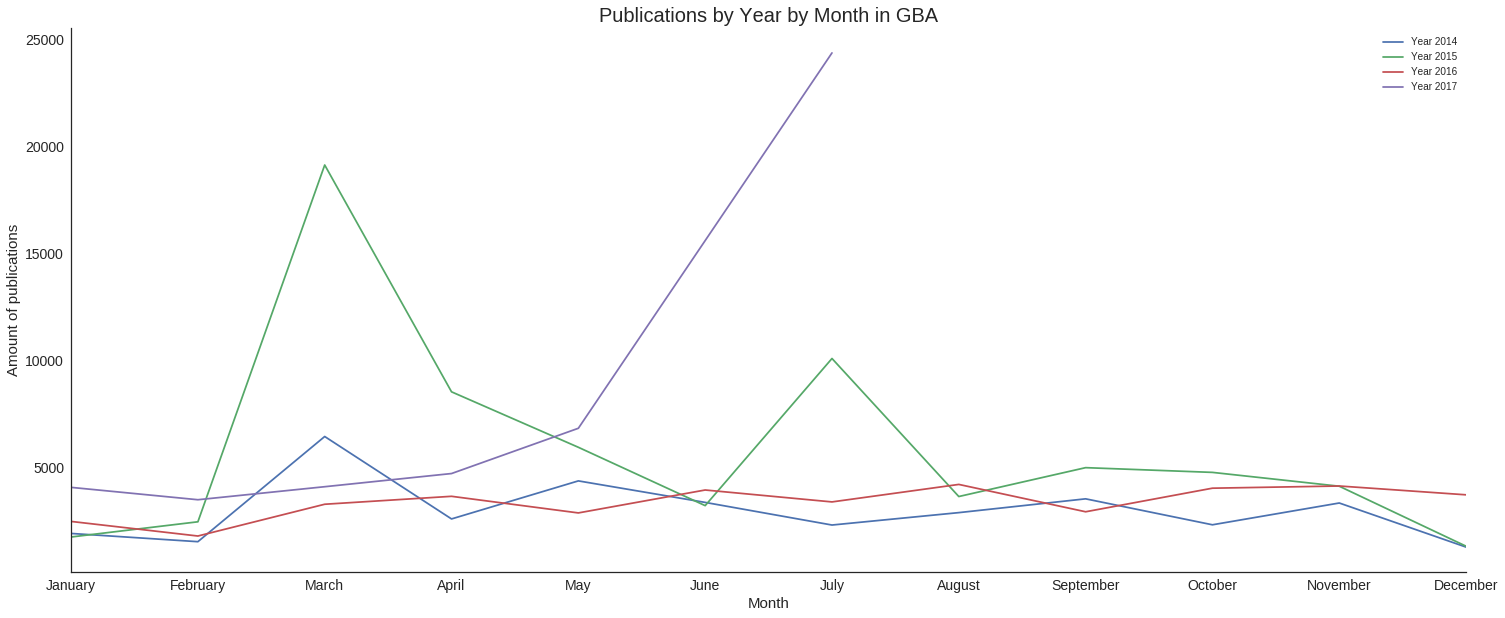

In [29]:
plotPublicationsByYearByMonth(gbaNewDataFrame, 'GBA')

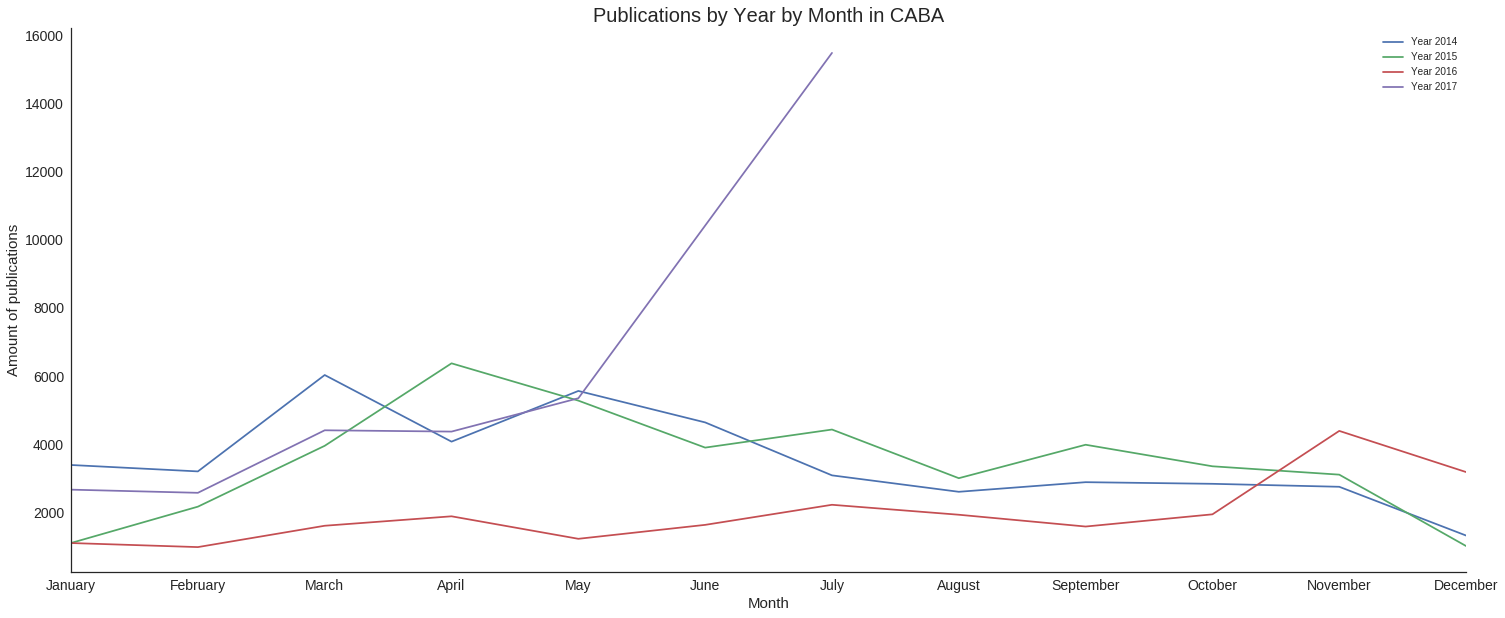

In [30]:
plotPublicationsByYearByMonth(cabaNewDataFrame, 'CABA')

How we can see on these plots, on average the number of publications is the same, but we see that between May 2017 and July 2017, the number of publications grew considerably in both CABA and GBA surpassing the double of the publications in average in the same date in both cases.

### How are the prices distributed?

We want to see how property prices are distributed, for this we can make a histogram with prices for each of the data frames (CABA and GBA).

In [31]:
cabaPricesDataFrame = cabaDataFrame[['price', 'geometry', 'property_type']]
gbaPricesDataFrame = gbaDataFrame[['price', 'geometry', 'property_type']]

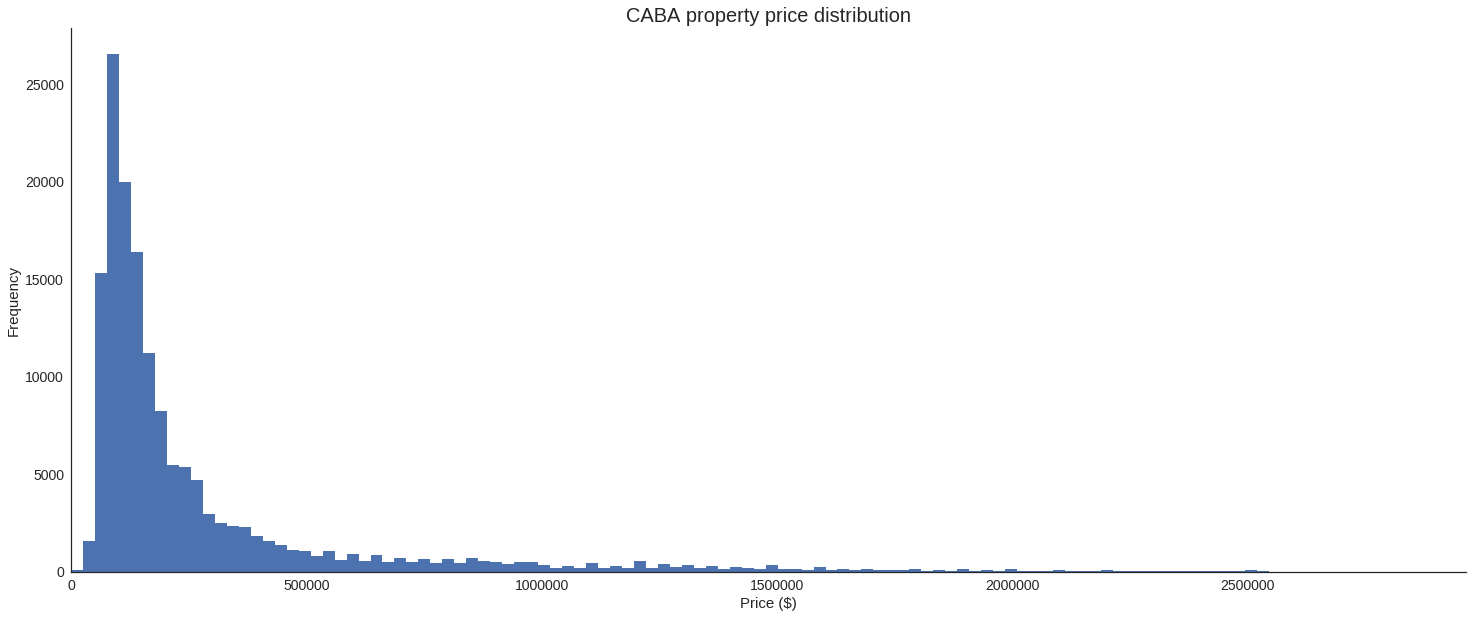

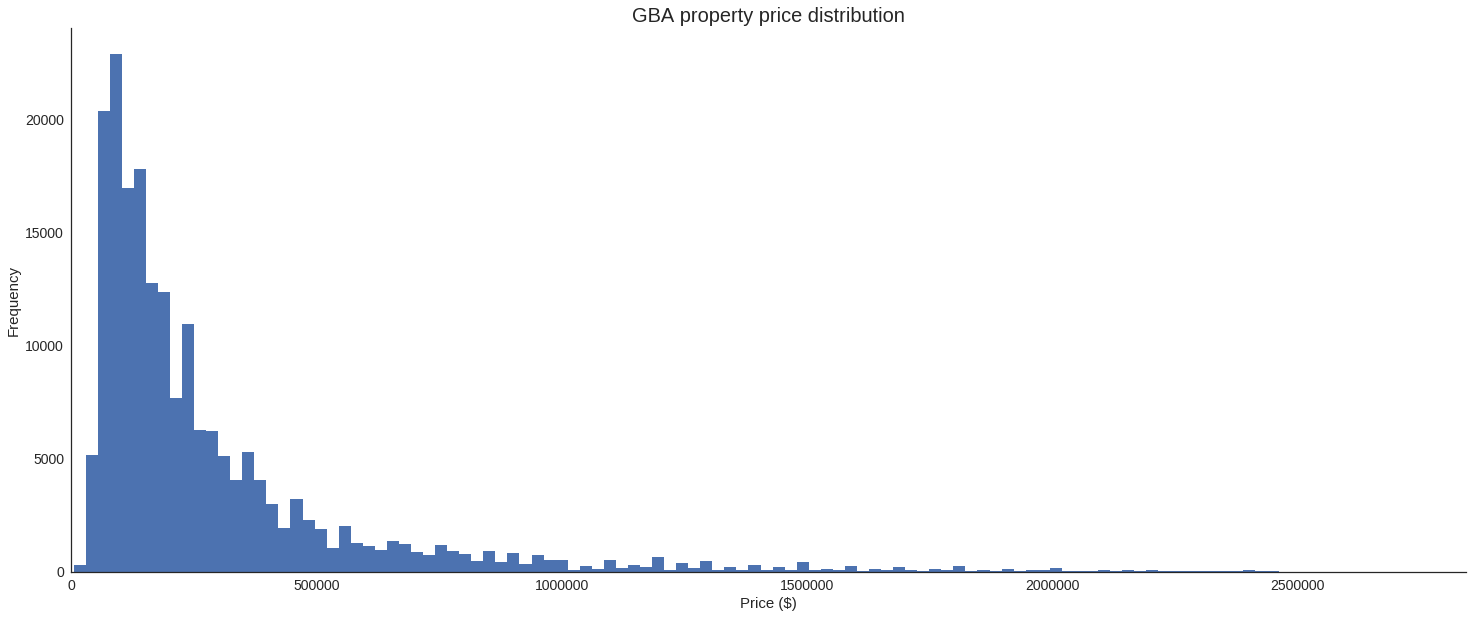

In [32]:
def plotPriceDistribution(dataFrame, isCABA=True):
    fig, ax = plt.subplots(1)

    ax.spines['top'].set_visible(False) 
    ax.spines['right'].set_visible(False)
        
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    title = '{0} property price distribution'.format('CABA' if isCABA else 'GBA')
    plt.title(title, fontsize=20)
    plt.xlabel('Price ($)', fontsize=15)
    plt.ylabel('Frequency', fontsize=15)
    
    ax.set_xlim(0, 4 * dataFrame.price.std())
    
    # Remove values that are further than three standard deviations from the mean value
    noOutliers = dataFrame[np.abs(dataFrame.price - dataFrame.price.mean()) <= (3 * dataFrame.price.std())]
    plt.hist(noOutliers.price, bins=100)

plotPriceDistribution(cabaPricesDataFrame)
plotPriceDistribution(gbaPricesDataFrame, isCABA=False)

How we can see in the last plots, prices in GBA are more distribuited than CABA. 

### How are the expenses distributed?

We want to see how property expenses are distributed, for this we can make a histogram with expenses for each of the data frames (CABA and GBA).

In [33]:
cabaExpensesDataFrame = cabaDataFrame[['expenses', 'geometry', 'property_type']]
gbaExpensesDataFrame = gbaDataFrame[['expenses', 'geometry', 'property_type']]

cabaExpensesDataFrame['expenses'] = pd.to_numeric(cabaExpensesDataFrame['expenses'], errors='coerce')
gbaExpensesDataFrame['expenses'] = pd.to_numeric(gbaExpensesDataFrame['expenses'], errors='coerce')

cabaExpensesDataFrame.dropna(axis=0, subset=['expenses'], inplace=True)
gbaExpensesDataFrame.dropna(axis=0, subset=['expenses'], inplace=True)

cabaExpensesDataFrame = cabaExpensesDataFrame[cabaExpensesDataFrame.expenses >= 0]
gbaExpensesDataFrame = gbaExpensesDataFrame[gbaExpensesDataFrame.expenses >= 0]

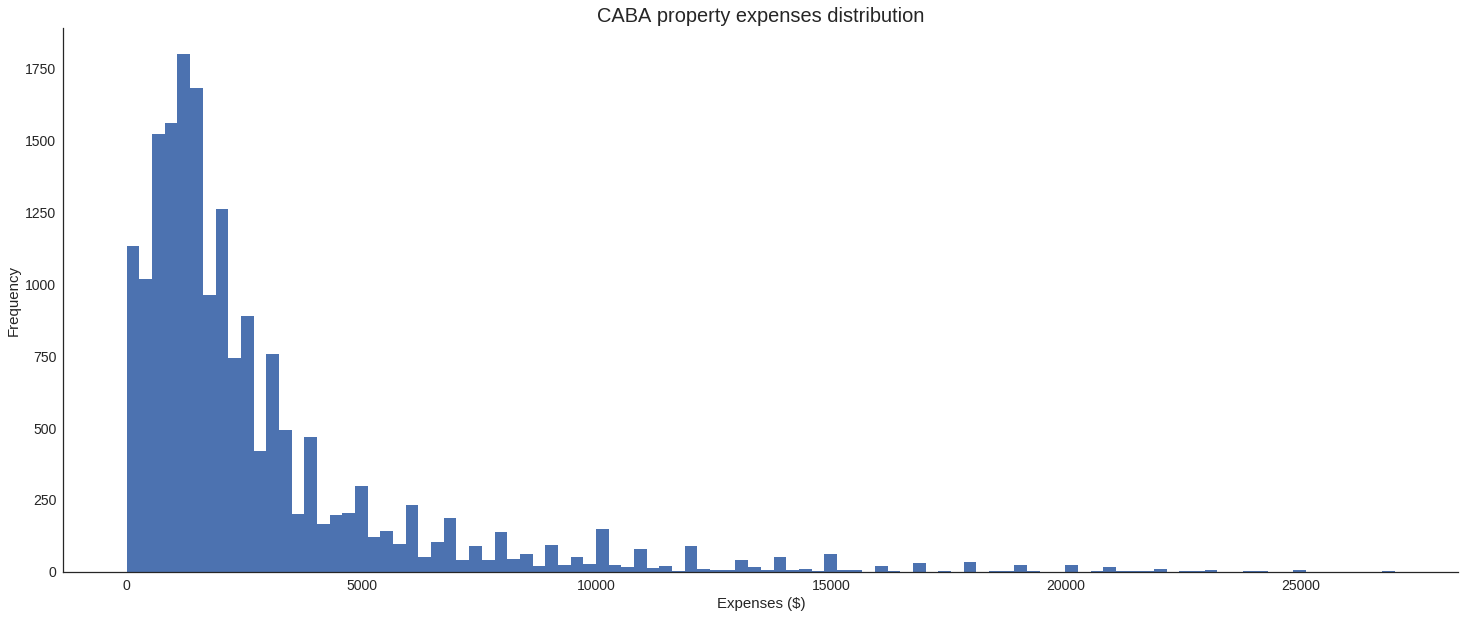

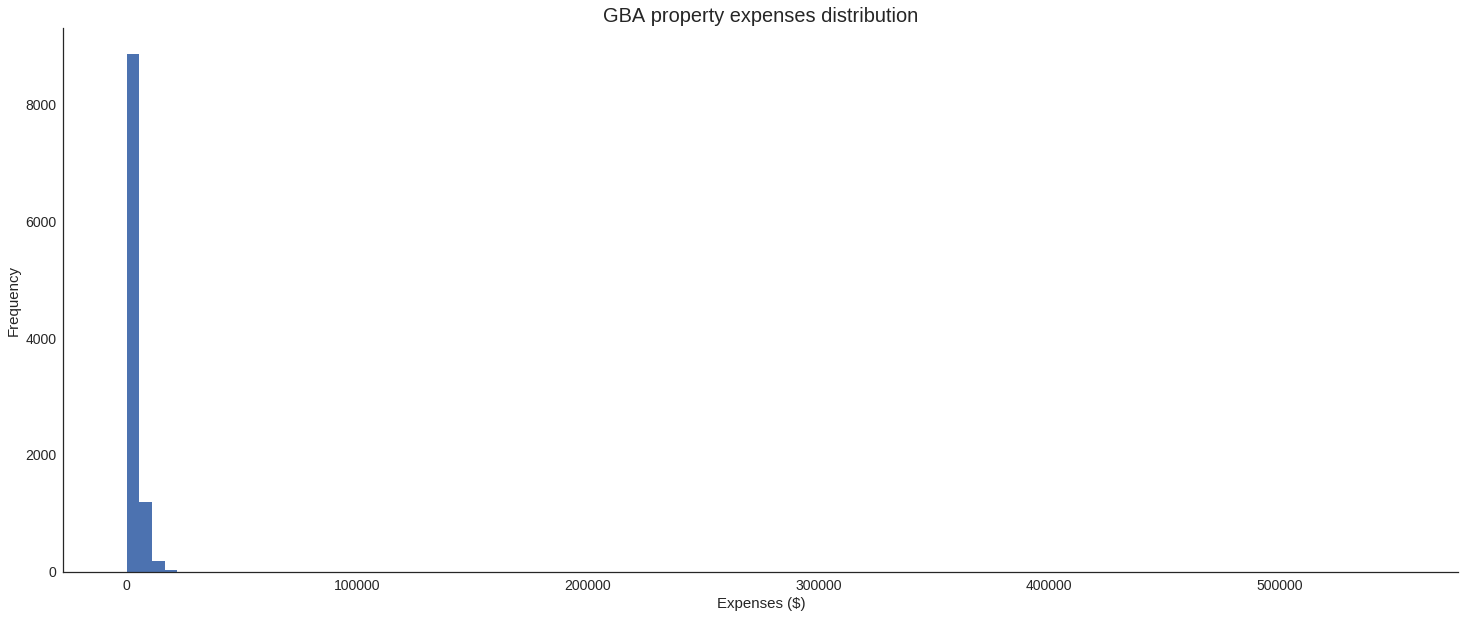

In [34]:
def plotExpensesDistribution(dataFrame, isCABA=True):
    fig, ax = plt.subplots(1)
    ax.spines['top'].set_visible(False) 
    ax.spines['right'].set_visible(False)
  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    title = '{0} property expenses distribution'.format('CABA' if isCABA else 'GBA')
    plt.title(title, fontsize=20)
    plt.xlabel('Expenses ($)', fontsize=15)
    plt.ylabel('Frequency', fontsize=15)
    
    # Remove values that are further than three standard deviations from the mean value
    noOutliers = dataFrame[np.abs(dataFrame.expenses - dataFrame.expenses.mean()) <= (3 * dataFrame.expenses.std())]
    plt.hist(noOutliers.expenses, bins=100, align='mid')
    
plotExpensesDistribution(cabaExpensesDataFrame)
plotExpensesDistribution(gbaExpensesDataFrame, isCABA=False)

In this case, the plot of expenses in GBA didn't result very well, this is because the "expenses" column in the dataset have got data which cannot be converted to *float* without apply some transformation in order to filter them. 

In the case of the plot from CABA, we can see the expenses are between \$0 and \$5000.

### Mean price distribution by location

With the following plots we want to analize how the prices are distribuited in both regions.

In [35]:
def plotHeatMapInMap(dataFrame, isCABA, columnName, title):
    geoDataFrame = gpd.GeoDataFrame(dataFrame, geometry='geometry')
    geoDataFrame.crs = {'init': 'epsg:4326'}
    
    if isCABA:
        mapGeoDataFrame = gpd.read_file('caba/comunas.shp')
        columnsToDrop = ['BARRIOS', 'PERIMETRO', 'AREA']
    else:
        mapGeoDataFrame = gpd.read_file('gba/municipios.shp')
        mapGeoDataFrame = mapGeoDataFrame[mapGeoDataFrame.PARTIDO != 'CIUDAD AUTONOMA DE BUENOS AIRES']
        columnsToDrop = ['ID', 'AREA', 'DATA', 'CODPARTIDO', 'PARTIDOBAR', 'CODPROVINC', 'PROVINCIA', 'CODPARTID1']

    mapGeoDataFrame.crs = {'init': 'epsg:4326'}        
    mapGeoDataFrame.drop(columnsToDrop, axis=1, inplace=True)
    joined = gpd.tools.sjoin(geoDataFrame, mapGeoDataFrame, how='right', op='intersects')

    colName = 'COMUNAS' if isCABA else 'PARTIDO'
    grouped = joined.groupby(colName).mean().reset_index().drop('index_left', axis=1)

    merged = pd.merge(mapGeoDataFrame, grouped, on=colName, how='right')
    
    fig, ax = plt.subplots(1)
    ax.set_aspect('equal')
    merged.plot(ax=ax, legend=True, column=columnName, cmap='Reds', scheme="Quantiles", edgecolor='black')
    ax.set_title(title, fontsize=20)
    ax.axis('off')

    plt.legend(fontsize=15)
    plt.show()

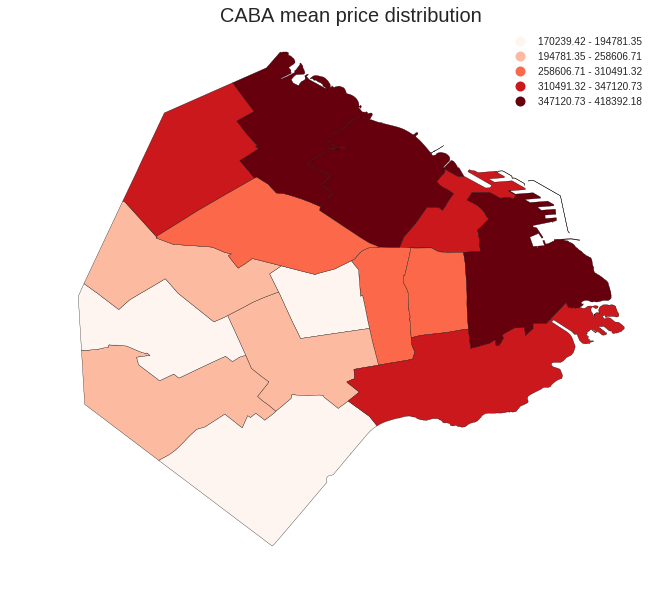

In [36]:
plotHeatMapInMap(cabaPricesDataFrame, True, 'price', 'CABA mean price distribution')

In [37]:
cabaPlaceNameMoreExpensive= cabaDataFrame[['place_name','price']]
cabaPlaceNameMoreExpensive['price'] = pd.to_numeric(cabaPlaceNameMoreExpensive['price'])
cabaPlaceNameMoreExpensive = cabaPlaceNameMoreExpensive.dropna()
cabaPlaceNameMoreExpensive = cabaPlaceNameMoreExpensive.groupby('place_name').mean().reset_index()
cabaPlaceNameMoreExpensive.sort_values('price',ascending=False).head(10)

,place_name,price
20,Distrito de las Artes,1312349.108108
42,Puerto Madero,821146.567393
31,Palermo Chico,555508.735613
44,Retiro,539819.387168
8,Boedo,533221.174340
46,San Cristobal,495951.110436
48,San Telmo,493462.354273
28,Nuñez,455171.685861
62,Villa Soldati,453998.220000
6,Belgrano,451131.473672


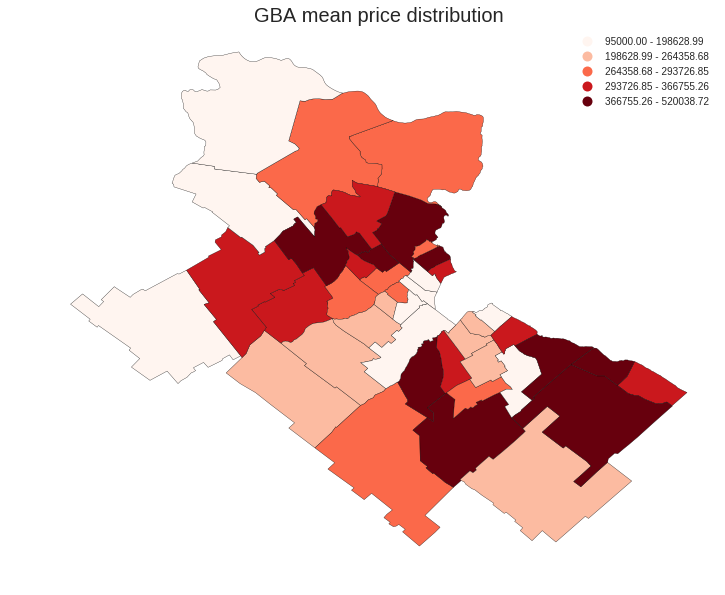

In [38]:
plotHeatMapInMap(gbaPricesDataFrame, False, 'price', 'GBA mean price distribution')

In [ ]:
gbaPlaceNameMoreExpensive= gbaDataFrame[['place_name','price']]
gbaPlaceNameMoreExpensive['price'] = pd.to_numeric(gbaPlaceNameMoreExpensive['price'])
gbaPlaceNameMoreExpensive = gbaPlaceNameMoreExpensive.dropna()
gbaPlaceNameMoreExpensive = gbaPlaceNameMoreExpensive.groupby('place_name').mean().reset_index()
gbaPlaceNameMoreExpensive.sort_values('price',ascending=False).head(10)

In CABA we can see that the propierties with highest mean price are the ones which are in the north zone or near the river. On the other hand, in GBA the higher prices are in the north zone but also in the south. We suspect that the private neighborhoods may influence in the distribution.

### Most expensive areas per square metre in CABA

In [39]:
cabaPlaceName= cabaDataFrame[['place_name','price_usd_per_m2']]
cabaPlaceName = cabaPlaceName.dropna()
cabaPlaceName = cabaPlaceName.groupby('place_name').mean().reset_index()
cabaPlaceName.sort_values('price_usd_per_m2',ascending=False).head(10)

,place_name,price_usd_per_m2
41,Puerto Madero,5549.154807
8,Boedo,4403.785576
45,San Cristobal,4280.911230
30,Palermo Chico,3608.371408
22,Las Cañitas,3296.143558
42,Recoleta,3151.001296
29,Palermo,3055.971604
32,Palermo Soho,3009.640955
31,Palermo Hollywood,2975.183273
33,Palermo Viejo,2946.629114


As we see here, the neighborhoods with more expensive price of m2 are the areas where on the map above we saw the most expensive properties.

### Most expensive areas per square metre in GBA

In [40]:
gbaPlaceName= gbaDataFrame[['place_name','price_usd_per_m2']]
gbaPlaceName = gbaPlaceName.dropna()
gbaPlaceName = gbaPlaceName.groupby('place_name').mean().reset_index()
gbaPlaceName.sort_values('price_usd_per_m2',ascending=False).head(10)

,place_name,price_usd_per_m2
325,Loma Hermosa,12090.973485
342,Manuel Alberti,7643.229902
48,"Barrio Cerrado ""La Delfina""",5488.771644
345,Manzone,3490.493932
416,San Isidro Chico,3423.521868
87,Barrio El Yacht,2955.698829
231,Enyoi,2906.201236
287,Islas del Canal,2755.588572
378,Pilar Golf Country Club,2648.176292
500,Virasoro Village,2576.923077


As we see here, the most expensive values pero M2 correspond to private neighborhoods in GBA.

### Mean expenses distribution by location

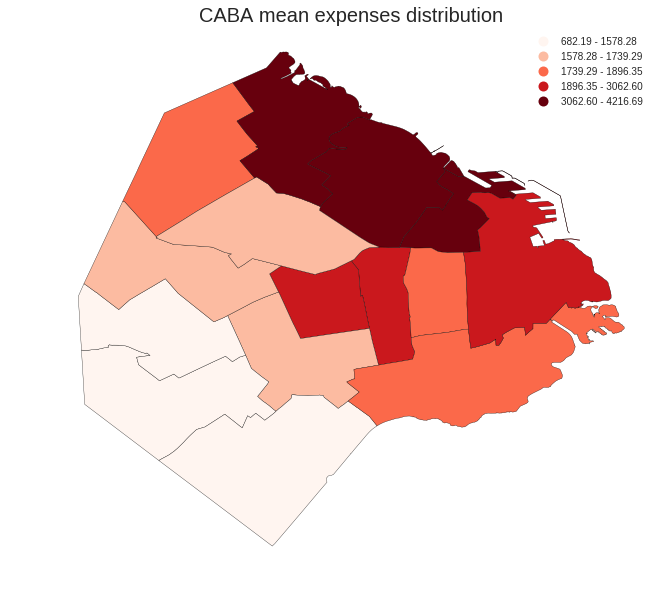

In [41]:
plotHeatMapInMap(cabaExpensesDataFrame, True, 'expenses', 'CABA mean expenses distribution')

Like the previous chart, the most expensive expenses are closely related to the most expensive properties.

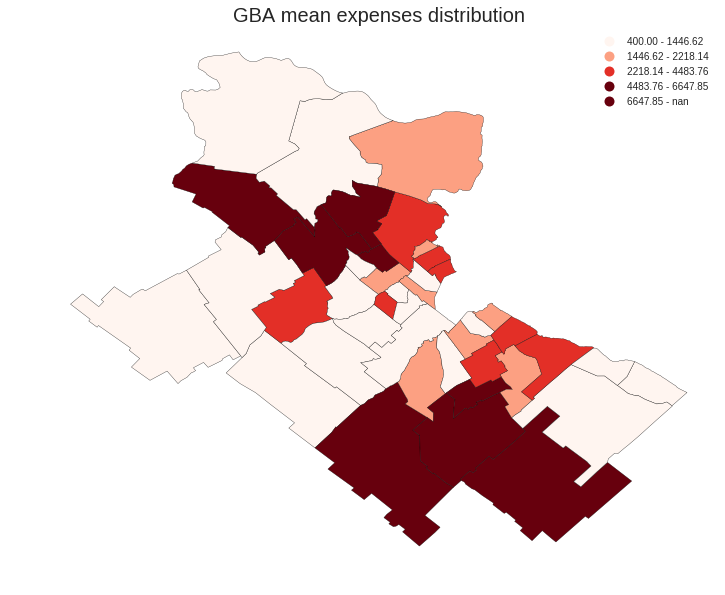

In [42]:
plotHeatMapInMap(gbaExpensesDataFrame, False, 'expenses', 'GBA mean expenses distribution')

As we saw above, we cannot get a correct data frame with the expenses distribution in GBA, therefore graph is not accurate.

### Mean price by property type



In [43]:
pricesDataFrame = cabaDataFrame[['price', 'property_type']].append(gbaDataFrame[['price', 'property_type']]).dropna()

In [44]:
grouped = pricesDataFrame.groupby('property_type').mean().reset_index()

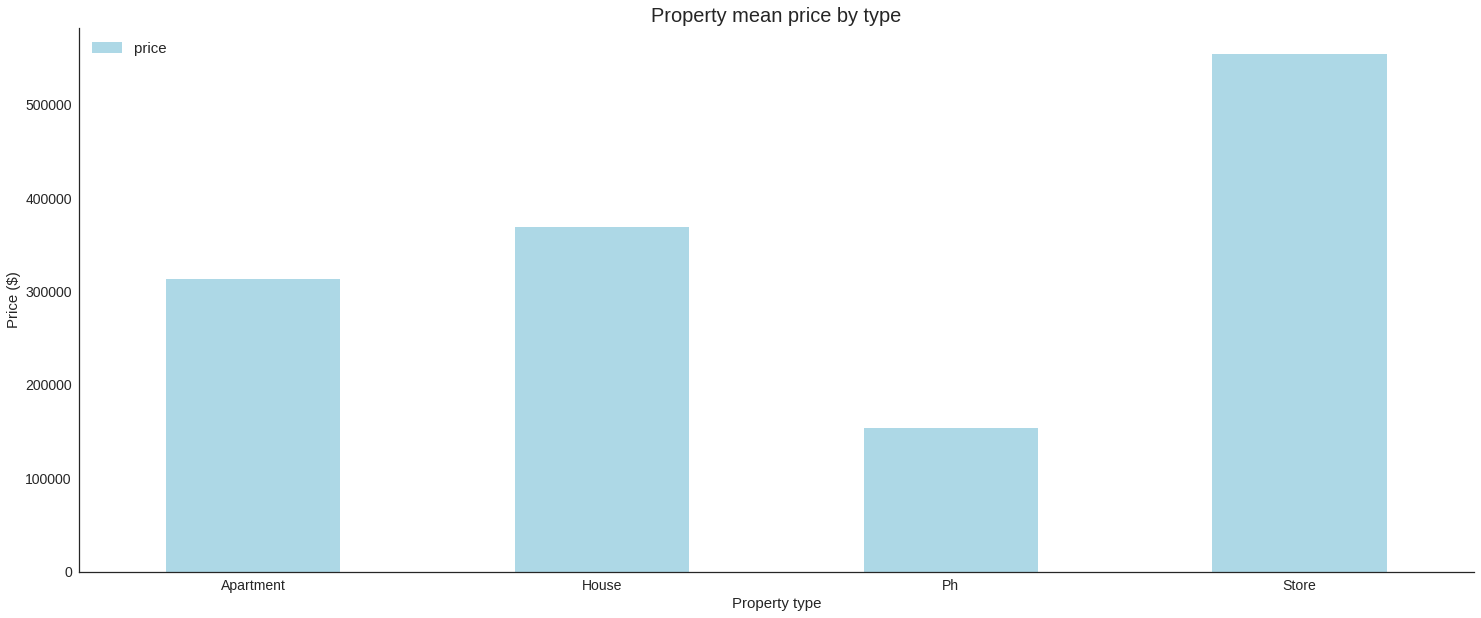

In [45]:
fig, ax = plt.subplots(1)
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

grouped.set_index('property_type').plot.bar(ax=ax, color='lightblue', rot=0)

plt.title('Property mean price by type', fontsize=20)
plt.xlabel('Property type', fontsize=15)
plt.ylabel('Price ($)', fontsize=15)
plt.legend(fontsize=15)
plt.show()

We can see that the most expensive properties on sale are "stores". At the same time, the houses are expensive than apartments which is completely logic.

Note: We've decided not to plot the mean expenses value by property type because we don't have a dataframe with the correct values.

### Geographic distribution by type of property

In this point, we what to show how the different properties are distributed over the map. 

In [49]:
def plotPointsInMap(dataFrame, isCABA, title, pointColor):
    geoDataFrame = gpd.GeoDataFrame(dataFrame, geometry='geometry')
    geoDataFrame.crs = {'init': 'epsg:4326'}
    
    if isCABA:
        mapGeoDataFrame = gpd.read_file('caba/comunas.shp')
        columnsToDrop = ['BARRIOS', 'PERIMETRO', 'AREA']
    else:
        mapGeoDataFrame = gpd.read_file('gba/municipios.shp')
        mapGeoDataFrame = mapGeoDataFrame[mapGeoDataFrame.PARTIDO != 'CIUDAD AUTONOMA DE BUENOS AIRES']
        columnsToDrop = ['ID', 'AREA', 'DATA', 'CODPARTIDO', 'PARTIDOBAR', 'CODPROVINC', 'PROVINCIA', 'CODPARTID1']

    mapGeoDataFrame.crs = {'init': 'epsg:4326'}
    mapGeoDataFrame.drop(columnsToDrop, axis=1, inplace=True)
    
    joinedGeoDataFrame = gpd.sjoin(geoDataFrame, mapGeoDataFrame, how="inner", op='intersects')
    
    fig, ax = plt.subplots(1)
    ax.set_aspect('equal')
    
    base = mapGeoDataFrame.plot(ax=ax, color='grey', edgecolor='black', alpha=0.7)
    joinedGeoDataFrame.plot(ax=base, marker="o", color=pointColor, markersize=5, alpha=0.5)
    _ = ax.axis('off')
    ax.set_title(title, fontsize=20)
    plt.show()

In [50]:
propertiesCabaDataFrame = cabaDataFrame[['property_type', 'geometry']].dropna()

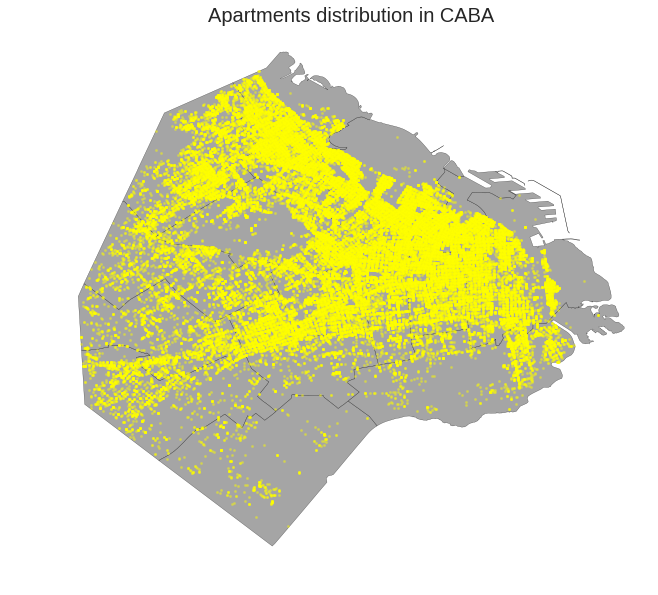

In [51]:
plotPointsInMap(propertiesCabaDataFrame[propertiesCabaDataFrame.property_type == 'Apartment'], True, 'Apartments distribution in CABA', 'yellow')

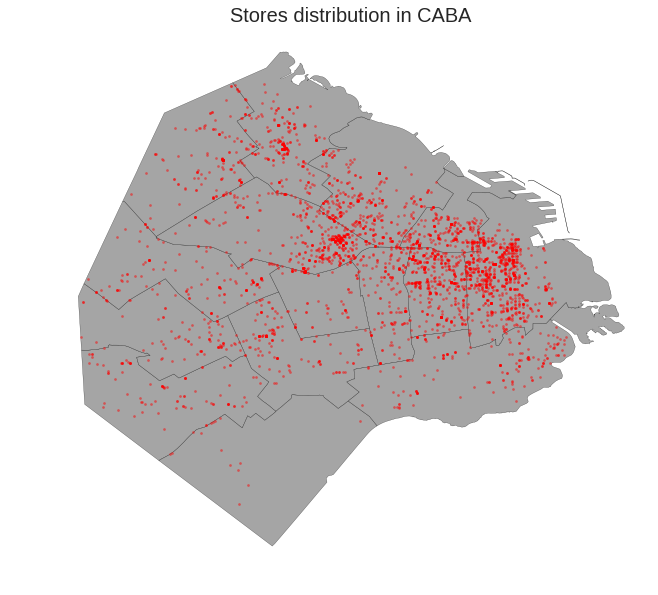

In [52]:
plotPointsInMap(propertiesCabaDataFrame[propertiesCabaDataFrame.property_type == 'Store'], True, 'Stores distribution in CABA', 'red')

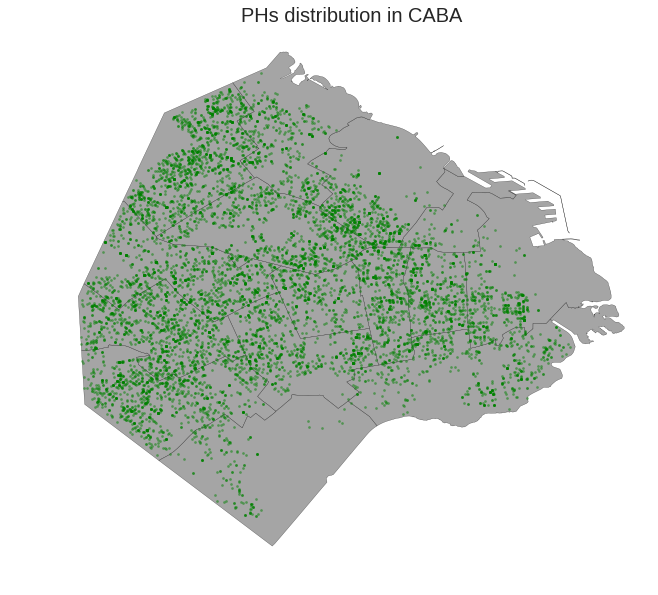

In [53]:
plotPointsInMap(propertiesCabaDataFrame[propertiesCabaDataFrame.property_type == 'Ph'], True, 'PHs distribution in CABA', 'green')

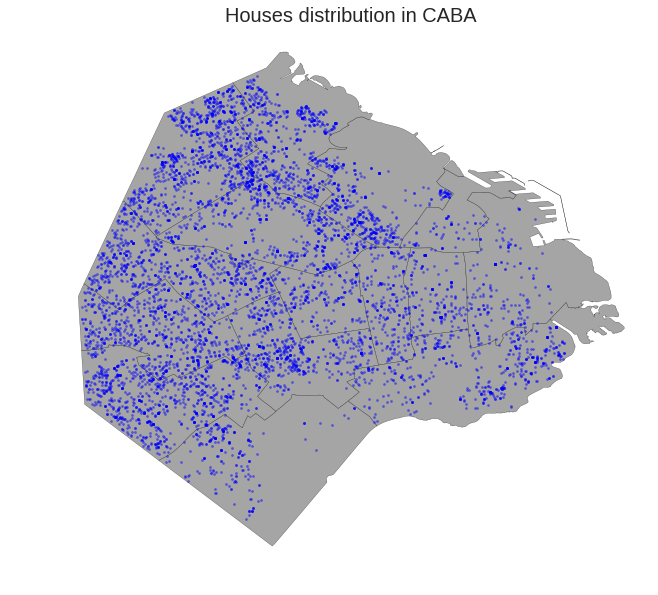

In [54]:
plotPointsInMap(propertiesCabaDataFrame[propertiesCabaDataFrame.property_type == 'House'], True, 'Houses distribution in CABA', 'blue')

On the latest plots we can see diferent things to analize. We see the *Houses* are more in the border of the map, located on the less centric areas, the same happend with *PH*s.

The *Appartment* properties appeared in all the map, showing that they are the predominant property type. And finally *Store*s are in all the map, but there are a dense concentration in commercial areas, for example in *Microcentro*.

In [55]:
propertiesGbaDataFrame = gbaDataFrame[['property_type', 'geometry']].dropna()

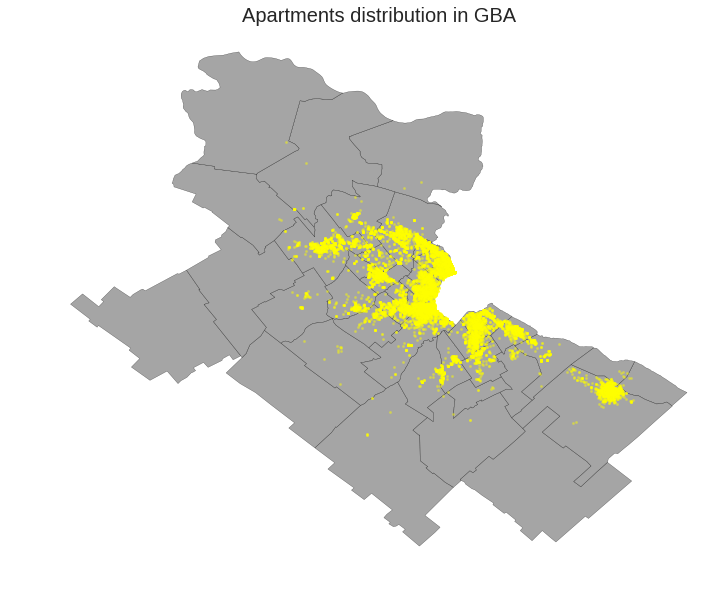

In [56]:
plotPointsInMap(propertiesGbaDataFrame[propertiesGbaDataFrame.property_type == 'Apartment'], False, 'Apartments distribution in GBA', 'yellow')

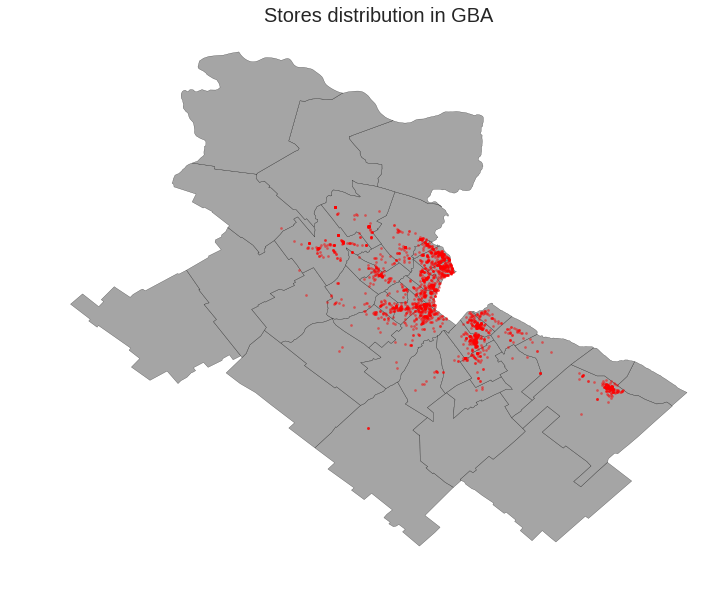

In [57]:
plotPointsInMap(propertiesGbaDataFrame[propertiesGbaDataFrame.property_type == 'Store'], False, 'Stores distribution in GBA', 'red')

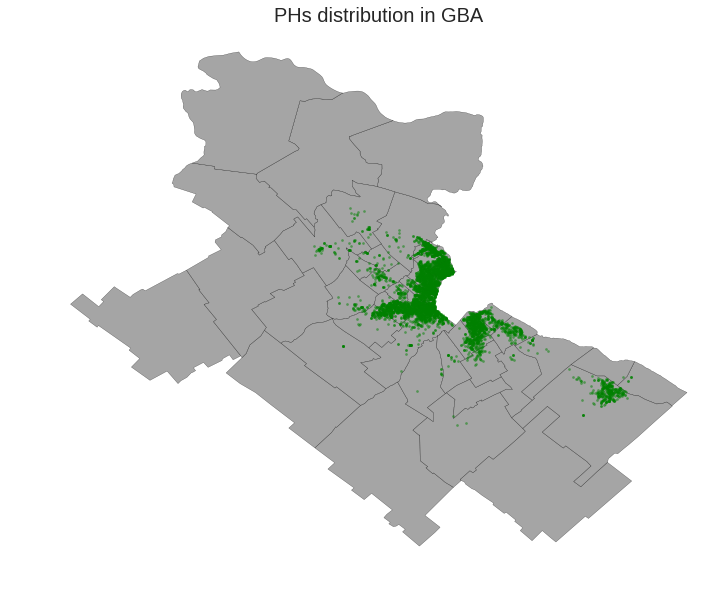

In [58]:
plotPointsInMap(propertiesGbaDataFrame[propertiesGbaDataFrame.property_type == 'Ph'], False, 'PHs distribution in GBA', 'green')

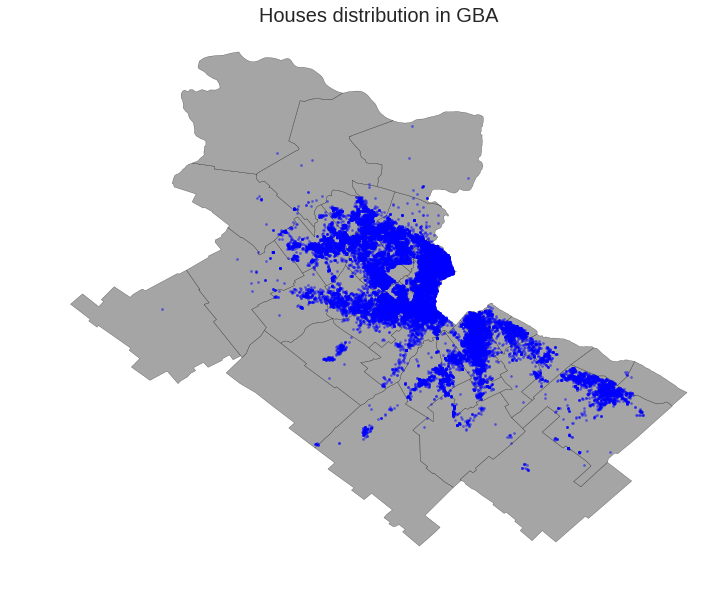

In [59]:
plotPointsInMap(propertiesGbaDataFrame[propertiesGbaDataFrame.property_type == 'House'], False, 'Houses distribution in GBA', 'blue')

Well, in the latest plots, we saw the houses are distribuited arround all the map, and the all property types are nearest to CABA.

### Description Analize

We will analize the property description to find some special content.

In [60]:
descriptionDataFrame = cabaDataFrame[['description', 'geometry']].append(gbaDataFrame[['description', 'geometry']]).dropna()

In [61]:
import re
def sanitizeString(text):
    text = text.lower().strip(' ')
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)   
    return text

descriptionDataFrame.description = descriptionDataFrame.description.map(sanitizeString)

In [62]:
def plotPointsInMap2(dataFrame, title):
    geoDataFrame = gpd.GeoDataFrame(dataFrame, geometry='geometry')
    geoDataFrame.crs = {'init': 'epsg:4326'}
    
    mapGeoDataFrame = gpd.read_file('gba/municipios.shp')
    columnsToDrop = ['ID', 'AREA', 'DATA', 'CODPARTIDO', 'PARTIDOBAR', 'CODPROVINC', 'PROVINCIA', 'CODPARTID1']

    mapGeoDataFrame.crs = {'init': 'epsg:4326'}
    mapGeoDataFrame.drop(columnsToDrop, axis=1, inplace=True)
    
    joinedGeoDataFrame = gpd.sjoin(geoDataFrame, mapGeoDataFrame, how="inner", op='intersects')
    
    fig, ax = plt.subplots(1)
    ax.set_aspect('equal')
    
    base = mapGeoDataFrame.plot(ax=ax, color='grey', edgecolor='black', alpha=0.7)
    joinedGeoDataFrame.plot(ax=base, marker="o", color='yellow', markersize=5, alpha=0.5)
    _ = ax.axis('off')
    ax.set_title(title, fontsize=20)
    plt.show()

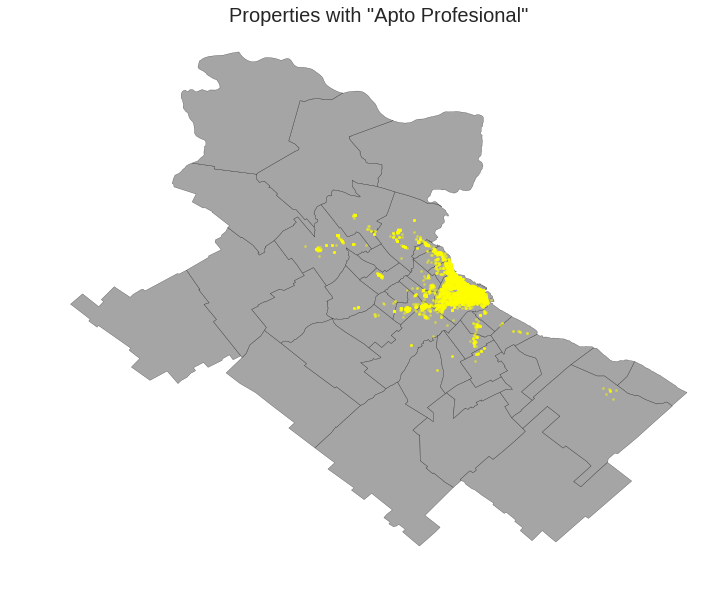

In [63]:
plotPointsInMap2(descriptionDataFrame[descriptionDataFrame.description.str.contains('apto prof')], 'Properties with "Apto Profesional"')

Properties which have *Apto Profesional* can be more, but only these showing in the publication description. As we can see, there are concentrated in CABA and near to it.

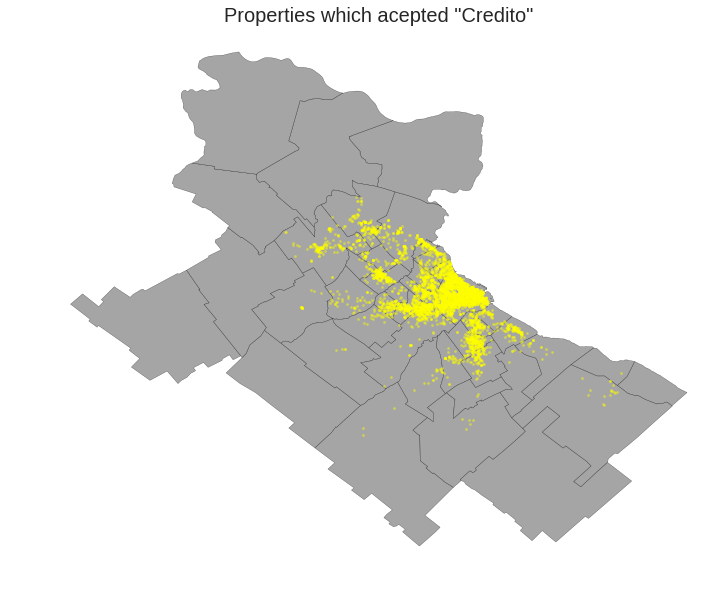

In [64]:
plotPointsInMap2(descriptionDataFrame[descriptionDataFrame.description.str.contains('cred')], 'Properties which acepted "Credito"')

Properties which accept *Credito* can be more, but only these showing in the publication description.

## Conclusions

As a conclusion we can highlight how can easily see the differences between property types in GBA and CABA. We expected that, but seeing it in a graphical way using maps and other graphs provide us a quick way to detect patters.

In addition, the price of the properties in many cases is determined by its location, showing us the purchasing power of the areas. Another factor which help us to determine the purchasing power is the density of publications, which show us a lack of publications in areas with low resources.

It is important to highlight how the appartments predominate over houses in CABA, and the tendency for departments to be in a single room. Also, the population density can be approximated using the amount of publications, which in ultimate instance show us the offer.

Finally, it is easy to see with the analysis that we did, as the poblation is concentrated in CABA

-----
As a future work and improvements, we can suggest the following ideas:

* Improve the heuristic for detect patterns using the description.
* Analyze the images provided in the dataset (we've started to do it, trying to find the most three predominant colors over all the images using KMeans but as there're around of 700 thousands images to process we cannot get any result).
* Analyze the rental of properties.
* Analyze the correlation of the price and the value of the dollar.